In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pylab

import seaborn as sns

import csv

import scipy
from scipy import stats
import statistics

In [2]:
%matplotlib inline
import deepdish as dd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import numpy as np
import brainiak.eventseg.event
from scipy import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve
from sklearn import decomposition
import seaborn as sns 

In [3]:
#import cupy as cp
from easyesn.optimizers import GradientOptimizer
from easyesn import PredictionESN
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp
import numpy as np
#from wikipedia2vec import Wikipedia2Vec

#import nltk
#nltk.download('stopwords')
#from nltk.corpus import stopwords


vectorDim = 100

numNode = 1000

reps = 20
kvalues = 20

# the data structures to save the means for the coherent and incoherent
coherent_means = np.empty(reps)
incoherent_means = np.empty(reps)

coherent_vars_1 = np.empty(reps)
coherent_vars_2 = np.empty(reps) 

incoherent_vars_1 = np.empty(reps)
incoherent_vars_2 = np.empty(reps) 

likelihood = np.zeros([kvalues,reps,2])



#here is a small bit of data to train the reservoir.  We dont care
# if it learns because we are analysing the reseroir units, and
#not the readouts

in_small = np.load('in_small.npy')
out_small = np.load('out_small.npy')

Using Numpy backend.


In [4]:
#reservoirStatesBuffer[:,:resn]


print(len(in_small))
print(len(out_small))

10000
10000


In [5]:
#here we import the word vectors for the intact and shifted 
# not the fall texts.  Avoids using the big wikipedia2vec pkl file

inputDataTestingIntact = np.load('inputDataTestingIntact.npy')
inputDataTestingShift = np.load('inputDataTestingShift.npy')


In [6]:
# now the radical loop: 1. run 2 reservoirs; 2. calculate time contst; 3.sort;  4. segment (ubuntu)

for res_seed in range(reps):
 
    ###################################################################
    #
    #               1.1 run reservoir on intact text


    # set the seed
    np.random.seed(res_seed)

    # set up the reservoir
    # leakingRate=0.2 changing too fast, mutliple with 0.05; changed
    esn = PredictionESN(n_input=vectorDim, n_output=vectorDim, n_reservoir=numNode, leakingRate=0.2, regressionParameters=[1e-2], solver="lsqr", feedback=False)

    # train the reervoir with a new seed
    esn.fit(in_small, out_small, transientTime="Auto", verbose=1)

    # modify the reservoir topology for input
    for i in range(700):
        for j in range(101):
            esn._WInput[i+300,j] = 0
    esn._WInput=esn._WInput*5

    # and for the reservoir _W matrix
    for i in range(esn._W.shape[0]):
        for j in range(esn._W.shape[1]):
            esn._W[i,j] = esn._W[i,j]* (1 + i * .0005)
            if abs(i-j) > 300:
                esn._W[i,j] = 0

    #run the reservoir
    reservoirStatesBuffer = np.empty((0,numNode))
    prediction,reservoirStatesBuffer  = esn.predict(inputDataTestingIntact)
    reservoirStatesBuffer = reservoirStatesBuffer.T
    print(reservoirStatesBuffer.shape)
    reservoirStatesBuffer = reservoirStatesBuffer[:,101:]
    print(reservoirStatesBuffer.shape)
    print(prediction.shape)

    reservoirStatesBuffer1 = reservoirStatesBuffer

    
    


    ###################################################################
    #
    #               4. Segment
    

    # get the pieces
    #NTF_time1=NTF_SortedStates[:,0:99]
    #NTF_time2=NTF_SortedStates[:,900:999]
    
    NTF_time1=reservoirStatesBuffer[:,200:299]
    NTF_time1test=reservoirStatesBuffer[:,300:399]

    
    NTF_time2=reservoirStatesBuffer[:,500:599]
    NTF_time2test=reservoirStatesBuffer[:,600:699]
 
    if res_seed == 0:
        NTF_time1_cumul = NTF_time1
        NTF_time2_cumul = NTF_time2
    else:
        NTF_time1_cumul = NTF_time1 + NTF_time1_cumul
        NTF_time2_cumul = NTF_time2 + NTF_time2_cumul
    
    # now test the different k values
    
    for iteration in range(kvalues):

        ###################################################################
        #
        #               4. Segment

        #simple data structure for testing
        

        step = 2
        # Train the two HMS with the predicted segments
        ev_time1 = brainiak.eventseg.event.EventSegment((iteration+1)*step)
        ev_time1.fit(NTF_time1)

        ev_time2 = brainiak.eventseg.event.EventSegment((iteration+1)*step)
        ev_time2.fit(NTF_time2)
        print((iteration+1)*step)

        # save the variablility scores

        coherent_ev1_var = ev_time1.event_var_
        coherent_ev2_var = ev_time2.event_var_
        
 

        # save likelihood scores
        #likelihood[iteration, res_seed,0] = ev_time1.ll_[len(ev_time1.ll_)-1]
        #likelihood[iteration, res_seed,1] = ev_time2.ll_[len(ev_time2.ll_)-1]
        a,likelihood[iteration, res_seed,0] = ev_time1.find_events(NTF_time1test)
        a,likelihood[iteration, res_seed,1] = ev_time2.find_events(NTF_time2test)


        print("res_seed = ", res_seed)
        print("Likelihood")
        print(*likelihood[iteration, res_seed,:], sep='\n')


100% (9904 of 9904) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
2
res_seed =  0
Likelihood
-1190.9038616810647
-1179.4410883926892
4
res_seed =  0
Likelihood
-1196.3831946747412
-1224.0882684493151
6
res_seed =  0
Likelihood
-1185.8909720655179
-1253.9562340261673
8
res_seed =  0
Likelihood
-1201.2496692367965
-1289.2997450781404
10
res_seed =  0
Likelihood
-1212.8474706445475
-1343.5539503614102
12
res_seed =  0
Likelihood
-1233.412484140397
-1398.6120148820469
14
res_seed =  0
Likelihood
-1212.7286862287262
-1494.0686779816658
16
res_seed =  0
Likelihood
-1248.7142089593513
-1566.9241464395234
18
res_seed =  0
Likelihood
-1240.216469255622
-1598.484419259827
20
res_seed =  0
Likelihood
-1260.9306473534436
-1668.9946247448472
22
res_seed =  0
Likelihood
-1276.2378211751286
-1764.5031694494426
24
res_seed =  0
Likelihood
-1286.020542438895
-1828.5916792038602
26
res_seed =  0
Likelihood
-1294.3358043577675
-1966.866624018444
28
res_seed =  0
Likelihood
-1307.2291112580929
-2045.0906092377882
30
res_seed =  0
Likel

100% (9906 of 9906) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(682, 1101)
(682, 1000)
(682, 100)
2
res_seed =  1
Likelihood
-1189.456133161217
-1204.752683796987
4
res_seed =  1
Likelihood
-1198.7947429631101
-1200.6666962677302
6
res_seed =  1
Likelihood
-1189.503123103967
-1233.7168923931097
8
res_seed =  1
Likelihood
-1195.8393852347274
-1272.3824539963018
10
res_seed =  1
Likelihood
-1187.7794661627258
-1305.5986216574104
12
res_seed =  1
Likelihood
-1200.8637814585838
-1382.4786204443838
14
res_seed =  1
Likelihood
-1215.3662442623106
-1418.8471953427788
16
res_seed =  1
Likelihood
-1242.0902602990998
-1509.6689142889852
18
res_seed =  1
Likelihood
-1255.5327413087418
-1609.653171301194
20
res_seed =  1
Likelihood
-1252.6202508623178
-1664.260914556845
22
res_seed =  1
Likelihood
-1262.0171937907576
-1755.4715465268498
24
res_seed =  1
Likelihood
-1275.0177383203109
-1836.3663279630225
26
res_seed =  1
Likelihood
-1286.6023635672768
-1909.4264008032023
28
res_seed =  1
Likelihood
-1300.9272321377318
-2020.827571535825
30
res_seed =  1
Likeli

100% (9902 of 9902) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
2
res_seed =  2
Likelihood
-1190.5602403456621
-1187.6598331640414
4
res_seed =  2
Likelihood
-1182.5615374178683
-1203.5251230918232
6
res_seed =  2
Likelihood
-1194.7711626863656
-1223.3887284819155
8
res_seed =  2
Likelihood
-1204.748452849447
-1228.2741322974305
10
res_seed =  2
Likelihood
-1214.1346497929417
-1280.836563014642
12
res_seed =  2
Likelihood
-1228.8861995561913
-1327.9228462134877
14
res_seed =  2
Likelihood
-1240.5234768692799
-1399.4574702657621
16
res_seed =  2
Likelihood
-1253.195438366355
-1479.75308257592
18
res_seed =  2
Likelihood
-1267.58178594585
-1574.2685212832848
20
res_seed =  2
Likelihood
-1269.6341431812325
-1633.7168521450703
22
res_seed =  2
Likelihood
-1284.8870753398942
-1731.429326137111
24
res_seed =  2
Likelihood
-1301.4621559625173
-1816.573250300123
26
res_seed =  2
Likelihood
-1317.5458557810307
-1884.2765032363077
28
res_seed =  2
Likelihood
-1335.3298881079365
-2018.212296950197
30
res_seed =  2
Likelihood

100% (9906 of 9906) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
2
res_seed =  3
Likelihood
-1190.2868373984606
-1158.6441621855483
4
res_seed =  3
Likelihood
-1179.3458202117065
-1190.5389899070092
6
res_seed =  3
Likelihood
-1195.5329231019734
-1217.888662081591
8
res_seed =  3
Likelihood
-1211.4586294201142
-1261.6043173579892
10
res_seed =  3
Likelihood
-1215.863347204473
-1307.1105236461444
12
res_seed =  3
Likelihood
-1215.7368105938206
-1371.245987893396
14
res_seed =  3
Likelihood
-1235.4597287406489
-1430.1078233897858
16
res_seed =  3
Likelihood
-1245.942108102458
-1494.4076010675208
18
res_seed =  3
Likelihood
-1259.3535254807296
-1541.9002869440005
20
res_seed =  3
Likelihood
-1276.7181141825604
-1592.0994799644122
22
res_seed =  3
Likelihood
-1292.3390935398731
-1683.2825040863424
24
res_seed =  3
Likelihood
-1284.3467872079605
-1725.3178770574493
26
res_seed =  3
Likelihood
-1301.8176722795754
-1864.0794910873285
28
res_seed =  3
Likelihood
-1318.8432653793345
-1860.6787182607281
30
res_seed =  3
Like

100% (9903 of 9903) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
2
res_seed =  4
Likelihood
-1176.1718942044295
-1165.0051933120208
4
res_seed =  4
Likelihood
-1182.0766244963854
-1179.732037165188
6
res_seed =  4
Likelihood
-1195.4001985318807
-1210.2151101134311
8
res_seed =  4
Likelihood
-1194.4813980142637
-1254.3774795958657
10
res_seed =  4
Likelihood
-1191.4326403263606
-1307.8447730146672
12
res_seed =  4
Likelihood
-1213.2121056630258
-1369.472529194023
14
res_seed =  4
Likelihood
-1228.690278986047
-1426.2692759736449
16
res_seed =  4
Likelihood
-1236.979663554691
-1498.60107814913
18
res_seed =  4
Likelihood
-1254.2648876413468
-1604.0448273453858
20
res_seed =  4
Likelihood
-1264.1884834970397
-1700.601836804854
22
res_seed =  4
Likelihood
-1279.747328289146
-1737.5612942855619
24
res_seed =  4
Likelihood
-1274.986065957553
-1830.0699248266033
26
res_seed =  4
Likelihood
-1291.5762029025334
-1931.530152348666
28
res_seed =  4
Likelihood
-1306.9480813032844
-2016.4344049701626
30
res_seed =  4
Likelihood

100% (9908 of 9908) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
2
res_seed =  5
Likelihood
-1203.563062160543
-1156.616086636654
4
res_seed =  5
Likelihood
-1176.512864717568
-1163.2843968695577
6
res_seed =  5
Likelihood
-1188.3864067300194
-1197.5507459104263
8
res_seed =  5
Likelihood
-1212.0561715449676
-1242.1185700061424
10
res_seed =  5
Likelihood
-1209.1623606022888
-1297.5308837189007
12
res_seed =  5
Likelihood
-1227.5886507027546
-1353.6546592653965
14
res_seed =  5
Likelihood
-1249.0692494933658
-1443.0546372714768
16
res_seed =  5
Likelihood
-1210.8229499832726
-1481.1971244276162
18
res_seed =  5
Likelihood
-1229.6491565212013
-1557.241492375383
20
res_seed =  5
Likelihood
-1238.7513767749417
-1647.0598192047423
22
res_seed =  5
Likelihood
-1253.9793227128741
-1709.489882179609
24
res_seed =  5
Likelihood
-1273.3546981766365
-1804.329229997998
26
res_seed =  5
Likelihood
-1298.43899266693
-1903.593165468218
28
res_seed =  5
Likelihood
-1309.2222212918477
-2013.599096557159
30
res_seed =  5
Likelihood

100% (9905 of 9905) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
2
res_seed =  6
Likelihood
-1159.8473463703108
-1158.0344922363602
4
res_seed =  6
Likelihood
-1179.8522998501069
-1180.267203014815
6
res_seed =  6
Likelihood
-1178.295248310189
-1225.0393839257167
8
res_seed =  6
Likelihood
-1192.4747642279492
-1263.3511541945077
10
res_seed =  6
Likelihood
-1214.1454919000143
-1303.177107695386
12
res_seed =  6
Likelihood
-1225.813662776276
-1356.8305276166689
14
res_seed =  6
Likelihood
-1221.7713709067507
-1403.334736198949
16
res_seed =  6
Likelihood
-1257.2185951180343
-1452.374661281914
18
res_seed =  6
Likelihood
-1248.4755384495604
-1523.3835456810027
20
res_seed =  6
Likelihood
-1262.5498959010413
-1606.8888253159478
22
res_seed =  6
Likelihood
-1279.3792972031722
-1644.970693769368
24
res_seed =  6
Likelihood
-1293.3334794671591
-1724.7607407263401
26
res_seed =  6
Likelihood
-1311.9359629401813
-1836.2963636921208
28
res_seed =  6
Likelihood
-1328.160011450874
-1913.095236005877
30
res_seed =  6
Likelihoo

100% (9903 of 9903) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
2
res_seed =  7
Likelihood
-1192.1604165872807
-1204.630203288325
4
res_seed =  7
Likelihood
-1197.531789418351
-1200.174757768595
6
res_seed =  7
Likelihood
-1186.3062445461856
-1236.7625880398818
8
res_seed =  7
Likelihood
-1201.742504626863
-1307.5205775012957
10
res_seed =  7
Likelihood
-1207.2204265461733
-1371.1070410159084
12
res_seed =  7
Likelihood
-1224.9256042942473
-1431.3575877404696
14
res_seed =  7
Likelihood
-1234.905473597151
-1510.1733207061195
16
res_seed =  7
Likelihood
-1202.6446951967853
-1581.3476718302104
18
res_seed =  7
Likelihood
-1215.1339129405949
-1654.6828014682455
20
res_seed =  7
Likelihood
-1227.4860255422807
-1761.2460552266775
22
res_seed =  7
Likelihood
-1247.4207985036462
-1824.8639429007512
24
res_seed =  7
Likelihood
-1257.9990721995443
-1939.8141929307767
26
res_seed =  7
Likelihood
-1269.8810306989603
-2024.8712308397164
28
res_seed =  7
Likelihood
-1291.2740885077774
-2192.3010052853792
30
res_seed =  7
Likel

100% (9901 of 9901) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
2
res_seed =  8
Likelihood
-1193.6204594462538
-1160.017335982955
4
res_seed =  8
Likelihood
-1165.3797349630913
-1198.637731944698
6
res_seed =  8
Likelihood
-1179.585586885561
-1222.4652561464513
8
res_seed =  8
Likelihood
-1194.391453357744
-1267.2975259460836
10
res_seed =  8
Likelihood
-1139.2024781514858
-1324.63445957517
12
res_seed =  8
Likelihood
-1150.1207828401552
-1369.652673759861
14
res_seed =  8
Likelihood
-1158.0183185383537
-1445.7824407409855
16
res_seed =  8
Likelihood
-1170.2056260781508
-1492.821272023318
18
res_seed =  8
Likelihood
-1180.8631662787423
-1570.385529240898
20
res_seed =  8
Likelihood
-1215.9224568701843
-1650.8173420607093
22
res_seed =  8
Likelihood
-1232.325846670217
-1750.7379546916713
24
res_seed =  8
Likelihood
-1229.1386526364097
-1849.3351622339524
26
res_seed =  8
Likelihood
-1244.4757726881408
-1951.7078882561937
28
res_seed =  8
Likelihood
-1260.7627296595792
-2020.1968979769865
30
res_seed =  8
Likelihood

100% (9910 of 9910) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
2
res_seed =  9
Likelihood
-1184.490795464368
-1211.446236958687
4
res_seed =  9
Likelihood
-1187.3546763072268
-1182.3499768458942
6
res_seed =  9
Likelihood
-1162.8887522564205
-1231.0893778134773
8
res_seed =  9
Likelihood
-1148.642829998768
-1300.9777453479269
10
res_seed =  9
Likelihood
-1162.077400147549
-1344.3235733819974
12
res_seed =  9
Likelihood
-1185.3280615204574
-1405.991451698553
14
res_seed =  9
Likelihood
-1194.5006443960513
-1453.5162858689268
16
res_seed =  9
Likelihood
-1213.5211993899754
-1518.3286164891545
18
res_seed =  9
Likelihood
-1222.7606782393616
-1586.913854551074
20
res_seed =  9
Likelihood
-1242.1985389005238
-1643.1428249107516
22
res_seed =  9
Likelihood
-1251.8965516842918
-1755.1723934115007
24
res_seed =  9
Likelihood
-1266.817656846041
-1822.9879809057952
26
res_seed =  9
Likelihood
-1282.6490799844028
-1898.5659244327533
28
res_seed =  9
Likelihood
-1277.947835771233
-1865.11102499024
30
res_seed =  9
Likelihood

100% (9899 of 9899) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
2
res_seed =  10
Likelihood
-1176.088498867972
-1171.2853108734687
4
res_seed =  10
Likelihood
-1187.0255066829202
-1176.317082220402
6
res_seed =  10
Likelihood
-1186.638666250657
-1227.2428801141093
8
res_seed =  10
Likelihood
-1200.8726109349723
-1206.7760549788984
10
res_seed =  10
Likelihood
-1185.9680152305095
-1292.9901905671286
12
res_seed =  10
Likelihood
-1156.1467774027185
-1340.1370365931075
14
res_seed =  10
Likelihood
-1166.6871057288404
-1320.0310451554722
16
res_seed =  10
Likelihood
-1181.4824914300461
-1378.9224877669828
18
res_seed =  10
Likelihood
-1193.866513983321
-1455.3130549511347
20
res_seed =  10
Likelihood
-1207.9612056403173
-1522.8631627691834
22
res_seed =  10
Likelihood
-1223.861321373767
-1594.4666194923498
24
res_seed =  10
Likelihood
-1233.6712761838985
-1750.6197798918759
26
res_seed =  10
Likelihood
-1248.4540643180485
-1845.5932425336612
28
res_seed =  10
Likelihood
-1272.64434910058
-1925.164523944373
30
res_seed

100% (9906 of 9906) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
2
res_seed =  11
Likelihood
-1164.0101238637258
-1194.171685833797
4
res_seed =  11
Likelihood
-1175.4363561316586
-1238.074757037691
6
res_seed =  11
Likelihood
-1180.104269520367
-1276.050784148934
8
res_seed =  11
Likelihood
-1201.3649571924664
-1305.0478508530855
10
res_seed =  11
Likelihood
-1216.9006329789663
-1298.1679181312309
12
res_seed =  11
Likelihood
-1175.3756096200332
-1367.808762547052
14
res_seed =  11
Likelihood
-1184.608774673029
-1429.5887474849064
16
res_seed =  11
Likelihood
-1204.4862034619698
-1515.5158348896282
18
res_seed =  11
Likelihood
-1211.0887933006593
-1580.6941480077649
20
res_seed =  11
Likelihood
-1227.7660239777822
-1674.3405208930287
22
res_seed =  11
Likelihood
-1222.8472135398338
-1725.5059006495371
24
res_seed =  11
Likelihood
-1254.979000422757
-1818.031137724028
26
res_seed =  11
Likelihood
-1252.152996209745
-1905.934145121812
28
res_seed =  11
Likelihood
-1269.336519994367
-1987.7891751768873
30
res_seed = 

100% (9906 of 9906) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
2
res_seed =  12
Likelihood
-1182.301089520507
-1187.9323008255674
4
res_seed =  12
Likelihood
-1195.3250852525564
-1205.3438806608303
6
res_seed =  12
Likelihood
-1206.0541921870522
-1196.4659417613511
8
res_seed =  12
Likelihood
-1221.9850843888141
-1251.7302471269297
10
res_seed =  12
Likelihood
-1211.7732226615428
-1286.5636260117428
12
res_seed =  12
Likelihood
-1206.09843847479
-1333.9663814642654
14
res_seed =  12
Likelihood
-1216.852228631978
-1406.4848810215078
16
res_seed =  12
Likelihood
-1232.5848983273836
-1471.9111367445712
18
res_seed =  12
Likelihood
-1247.4749611980687
-1565.9084082518461
20
res_seed =  12
Likelihood
-1259.6729231268068
-1664.3716452291803
22
res_seed =  12
Likelihood
-1276.2084394332437
-1728.5952668103907
24
res_seed =  12
Likelihood
-1293.0531737121116
-1820.4560665455158
26
res_seed =  12
Likelihood
-1298.578416980453
-1922.6911453798455
28
res_seed =  12
Likelihood
-1302.6213640735596
-2004.3258133315671
30
res_s

100% (9901 of 9901) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
2
res_seed =  13
Likelihood
-1190.9852313490119
-1173.3865213774845
4
res_seed =  13
Likelihood
-1204.1210736144535
-1220.7436425586218
6
res_seed =  13
Likelihood
-1190.4218730847394
-1206.3891454042996
8
res_seed =  13
Likelihood
-1189.3925037836464
-1230.0425722332452
10
res_seed =  13
Likelihood
-1202.4197823830252
-1275.0188792370361
12
res_seed =  13
Likelihood
-1202.610975678791
-1334.9145199019888
14
res_seed =  13
Likelihood
-1221.6685914859227
-1404.5667047730567
16
res_seed =  13
Likelihood
-1228.1140365439355
-1473.176411808261
18
res_seed =  13
Likelihood
-1242.2723350852411
-1550.5555020456336
20
res_seed =  13
Likelihood
-1262.7282292255973
-1607.0508645418788
22
res_seed =  13
Likelihood
-1269.4374522985688
-1684.8320220505352
24
res_seed =  13
Likelihood
-1281.2829589119697
-1814.4722345386137
26
res_seed =  13
Likelihood
-1286.298848244172
-1773.9985705429674
28
res_seed =  13
Likelihood
-1302.8685669263714
-1896.658431148412
30
res_

100% (9901 of 9901) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
2
res_seed =  14
Likelihood
-1142.9206201512895
-1210.8288800893504
4
res_seed =  14
Likelihood
-1159.0410952948318
-1129.740668775523
6
res_seed =  14
Likelihood
-1166.248338232153
-1159.8154350241043
8
res_seed =  14
Likelihood
-1177.0876341022717
-1191.9550364797756
10
res_seed =  14
Likelihood
-1195.7126734114393
-1232.5677698374009
12
res_seed =  14
Likelihood
-1203.1463980381939
-1278.3544999149653
14
res_seed =  14
Likelihood
-1220.1493012054286
-1329.3338518297203
16
res_seed =  14
Likelihood
-1220.9306577595992
-1388.8162779552868
18
res_seed =  14
Likelihood
-1249.161253037375
-1507.2999178617272
20
res_seed =  14
Likelihood
-1259.746372928327
-1588.6895661168717
22
res_seed =  14
Likelihood
-1275.9848492683532
-1695.5119287627754
24
res_seed =  14
Likelihood
-1285.5417553779364
-1785.5509773917963
26
res_seed =  14
Likelihood
-1290.3852834278928
-1909.2132231485955
28
res_seed =  14
Likelihood
-1300.9762137123566
-2019.8016483796266
30
res_

100% (9901 of 9901) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
2
res_seed =  15
Likelihood
-1198.2178773827948
-1184.872390954897
4
res_seed =  15
Likelihood
-1171.798464057796
-1215.2234213133245
6
res_seed =  15
Likelihood
-1183.6754855022662
-1243.259269369167
8
res_seed =  15
Likelihood
-1204.1695612005203
-1266.7392086539878
10
res_seed =  15
Likelihood
-1160.6553865957494
-1332.8293511580325
12
res_seed =  15
Likelihood
-1204.6454529320383
-1343.8051096775926
14
res_seed =  15
Likelihood
-1210.7219776221827
-1448.979211571334
16
res_seed =  15
Likelihood
-1225.7582261398557
-1493.5461107362605
18
res_seed =  15
Likelihood
-1241.2760996800905
-1527.2122634936052
20
res_seed =  15
Likelihood
-1251.4715481267394
-1593.985714355582
22
res_seed =  15
Likelihood
-1262.6527273658812
-1689.4846005094294
24
res_seed =  15
Likelihood
-1275.8931007950575
-1751.090989027751
26
res_seed =  15
Likelihood
-1262.0213535273856
-1841.8279292385782
28
res_seed =  15
Likelihood
-1299.733757569602
-1946.3401792843053
30
res_see

100% (9901 of 9901) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
2
res_seed =  16
Likelihood
-1185.9352410866718
-1171.1757228113192
4
res_seed =  16
Likelihood
-1175.921631939963
-1197.5733391043266
6
res_seed =  16
Likelihood
-1194.1901786683627
-1248.430370489983
8
res_seed =  16
Likelihood
-1191.3518413044185
-1305.0307141725737
10
res_seed =  16
Likelihood
-1204.7516510224123
-1364.9133511414805
12
res_seed =  16
Likelihood
-1223.7295916940197
-1429.466514150991
14
res_seed =  16
Likelihood
-1238.2410768038096
-1496.135222199947
16
res_seed =  16
Likelihood
-1235.52430273575
-1559.0963166056674
18
res_seed =  16
Likelihood
-1249.7357816836566
-1655.2872003109383
20
res_seed =  16
Likelihood
-1283.8041618176164
-1758.7716819761692
22
res_seed =  16
Likelihood
-1290.1087507923107
-1844.5497730976074
24
res_seed =  16
Likelihood
-1285.8626660846667
-1981.780777534561
26
res_seed =  16
Likelihood
-1300.6382643406487
-2097.5215524502005
28
res_seed =  16
Likelihood
-1317.5667626832312
-2158.6964511931064
30
res_see

100% (9905 of 9905) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
2
res_seed =  17
Likelihood
-1131.4200785748685
-1157.0959204256096
4
res_seed =  17
Likelihood
-1138.2920523980576
-1161.116678403506
6
res_seed =  17
Likelihood
-1148.7989499144207
-1194.739637479453
8
res_seed =  17
Likelihood
-1169.9216320820228
-1240.6542423937242
10
res_seed =  17
Likelihood
-1162.3299668008935
-1297.2704477976704
12
res_seed =  17
Likelihood
-1174.9803517761081
-1352.7582984396652
14
res_seed =  17
Likelihood
-1209.391572149317
-1403.4962253111855
16
res_seed =  17
Likelihood
-1222.2226816539865
-1464.2013870088738
18
res_seed =  17
Likelihood
-1235.6489811016195
-1543.9521249902361
20
res_seed =  17
Likelihood
-1249.7086557564355
-1629.6932079198223
22
res_seed =  17
Likelihood
-1265.1716109484294
-1652.093611177852
24
res_seed =  17
Likelihood
-1284.8064464569457
-1735.794344085739
26
res_seed =  17
Likelihood
-1301.7180112878514
-1827.3535324168968
28
res_seed =  17
Likelihood
-1319.6146092734277
-1939.5340240864666
30
res_s

100% (9903 of 9903) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
2
res_seed =  18
Likelihood
-1169.4345693444673
-1185.8358090999716
4
res_seed =  18
Likelihood
-1187.8348624604484
-1211.9957001763364
6
res_seed =  18
Likelihood
-1168.2958536674842
-1258.051490840004
8
res_seed =  18
Likelihood
-1182.2622826071288
-1264.4373716169546
10
res_seed =  18
Likelihood
-1161.3661591304883
-1315.6343298431937
12
res_seed =  18
Likelihood
-1225.1422701888662
-1389.1092325755037
14
res_seed =  18
Likelihood
-1236.7175685496354
-1445.0972407638928
16
res_seed =  18
Likelihood
-1164.0827582104057
-1493.9559694535487
18
res_seed =  18
Likelihood
-1172.0391977468169
-1556.88540632442
20
res_seed =  18
Likelihood
-1186.9998720474284
-1619.2712809585344
22
res_seed =  18
Likelihood
-1199.7556662106442
-1681.1753823914514
24
res_seed =  18
Likelihood
-1212.658055454655
-1765.5748162761956
26
res_seed =  18
Likelihood
-1227.068249768129
-1859.4587513848355
28
res_seed =  18
Likelihood
-1244.8107233943394
-1920.985566422217
30
res_se

100% (9905 of 9905) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
2
res_seed =  19
Likelihood
-1205.6225095414009
-1212.2693674038753
4
res_seed =  19
Likelihood
-1181.8536713089698
-1203.8547280676116
6
res_seed =  19
Likelihood
-1195.7419290763396
-1233.9304118818761
8
res_seed =  19
Likelihood
-1206.0869666708172
-1278.7400328376862
10
res_seed =  19
Likelihood
-1161.8764498789155
-1322.7074219597666
12
res_seed =  19
Likelihood
-1168.9506443154457
-1383.4720532587046
14
res_seed =  19
Likelihood
-1180.174683404237
-1421.591860373886
16
res_seed =  19
Likelihood
-1192.1505041350067
-1491.684774254872
18
res_seed =  19
Likelihood
-1204.9796178195982
-1572.0538725915542
20
res_seed =  19
Likelihood
-1231.0321978648874
-1625.4989329549126
22
res_seed =  19
Likelihood
-1245.5664960054414
-1724.1836153473607
24
res_seed =  19
Likelihood
-1267.483209763241
-1815.4706458184996
26
res_seed =  19
Likelihood
-1277.8843150835241
-1939.6565820984786
28
res_seed =  19
Likelihood
-1305.441549887744
-2050.3120342004877
30
res_s

In [7]:
#for the figure get the mean reservoir states
NTF_time1_last = NTF_time1
NTF_time2_last = NTF_time2

#np.save('NTF-time1-last-june10.npy', NTF_time1) 
#np.save('NTF-time2-last-june10.npy', NTF_time2) 



In [8]:
NTF_time1 = NTF_time1_cumul/reps
NTF_time2 = NTF_time2_cumul/reps

In [9]:
#save the data likelihood
#np.save('NTF-time1-june10.npy', NTF_time1) 
#np.save('NTF-time2-june10.npy', NTF_time2) 

#np.save('likelihood-june10.npy', likelihood) 

In [48]:
NTF_time1 = NTF_time1_last
NTF_time2 = NTF_time2_last

In [49]:
# sement and make figure

ev_time1 = brainiak.eventseg.event.EventSegment(22)
ev_time1.fit(NTF_time1)

ev_time2 = brainiak.eventseg.event.EventSegment(8)
ev_time2.fit(NTF_time2)




#save the data likelihood
#np.save('NTF-time1-june6.npy', NTF_time1) 
#np.save('NTF-time2-june6.npy', NTF_time2) 

#np.save('likelihood-june6.npy', likelihood) 

EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0.]), n_events=8)

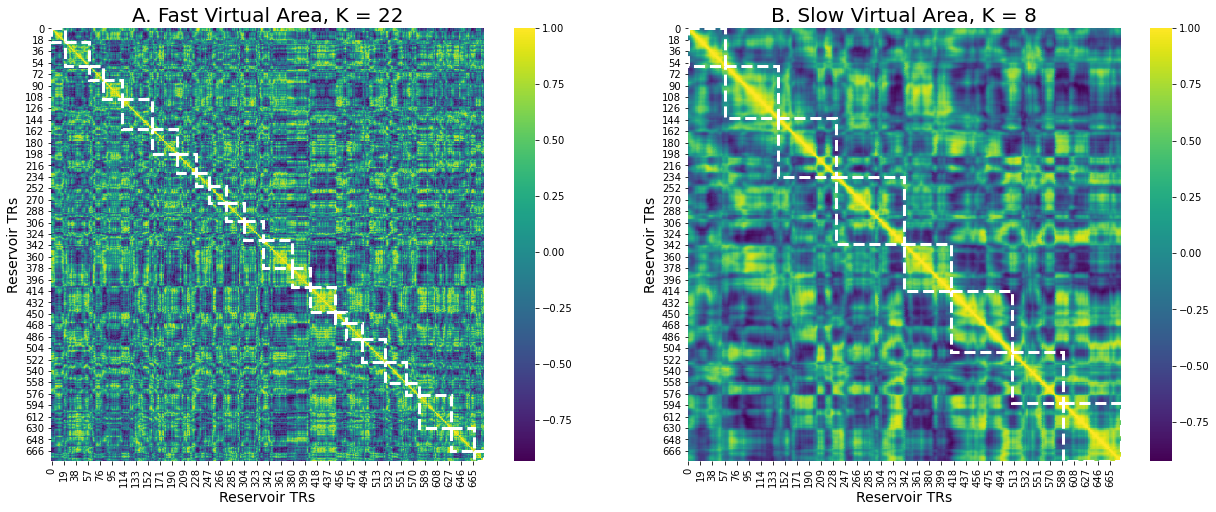

In [50]:
# 3 display the segmentation
color='viridis'
ec='white'
scale=0.9
lw=3

fs1 = 14
fs2 = 20

nTR=682
fig=plt.figure(figsize=(18, 7))

fig.add_subplot(121)
bounds = np.where(np.diff(np.argmax(ev_time1.segments_[0], axis=1)))[0]

#plt.imshow(np.corrcoef(NTF_time1),cmap=color, vmin=scale, vmax=1)
#plt.imshow(np.corrcoef(NTF_time1),cmap=color)
sns.heatmap(np.corrcoef(NTF_time1), cmap = 'viridis',square=True)

ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=lw, linestyle='--',edgecolor=ec,facecolor='none')
    ax.add_patch(rect)

plt.xlabel('Reservoir TRs', fontsize = fs1)
plt.ylabel('Reservoir TRs', fontsize = fs1)

plt.title('A. Fast Virtual Area, K = 22', fontsize = fs2)

fig.add_subplot(122)
bounds = np.where(np.diff(np.argmax(ev_time2.segments_[0], axis=1)))[0]

#plt.imshow(np.corrcoef(NTF_time2),cmap=color, vmin=scale, vmax=1)
#plt.imshow(np.corrcoef(NTF_time2),cmap=color)
sns.heatmap(np.corrcoef(NTF_time2), cmap = 'viridis',square=True)

ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=lw, linestyle='--',edgecolor=ec,facecolor='none')
    ax.add_patch(rect)

plt.xlabel('Reservoir TRs', fontsize = fs1)
plt.ylabel('Reservoir TRs', fontsize = fs1)

plt.title('B. Slow Virtual Area, K = 8', fontsize = fs2)


fig.tight_layout()
plt.savefig('CHARM13072021.png')

In [13]:
tmatrix=np.zeros([kvalues,kvalues])
pmatrix=np.zeros([kvalues,kvalues])
dmatrix=np.zeros([kvalues,kvalues])
                  

In [39]:
#likelihood = np.zeros([kvalues,reps,fastslow])
# compare all k pairs to see if the p values are significant

for j in range(kvalues):
    for i in range(j):
        # when i < j
        anti = (likelihood[i,:,0]+ likelihood[j,:,1])/2 # small k with fast area + large k with slow area 
        pro = (likelihood[j,:,0]+ likelihood[i,:,1])/2  # large k with fast area + small k with slow area
        dmatrix[i,j]=np.mean(pro-anti)
        t,p = stats.ttest_rel(pro,anti)
        tmatrix[i,j]=t
        pmatrix[i,j]=p
        #if t > 0 and p< 0.01:
        if t> 0 and p<0.001:
            print(i,j,t,p)


0 2 5.031230749078852 7.414791704783632e-05
1 2 5.520336538496852 2.520673999243996e-05
0 3 7.070514606638518 9.972368565469815e-07
1 3 6.7712634227945765 1.8152310219171474e-06
2 3 4.375980332492387 0.0003250000359434585
0 4 9.717047459383279 8.339868809498844e-09
1 4 11.319107376700991 6.903592257363945e-10
2 4 9.624942427171982 9.707306882709004e-09
3 4 7.253937202780044 6.949463906674782e-07
0 5 14.476434622712167 1.0265200742083503e-11
1 5 17.110394233898948 5.320642557950187e-13
2 5 16.302162479762153 1.2617703947838891e-12
3 5 14.800200686788077 6.966562838982779e-12
4 5 7.213130874936251 7.527908702003344e-07
0 6 15.897961005137415 1.9709267095306935e-12
1 6 22.665770279708095 3.237886095526397e-15
2 6 20.31542383557284 2.3957971430711458e-14
3 6 22.278362960127968 4.4422661940941275e-15
4 6 14.204393203780477 1.4298534485346984e-11
5 6 7.195314434022633 7.795885316494319e-07
0 7 19.215792339653795 6.581491533341368e-14
1 7 24.586725416627715 7.24585679240648e-16
2 7 23.9988056

(20, 20)
49
1.4466575056079345e-18
6.964662449787266e-15


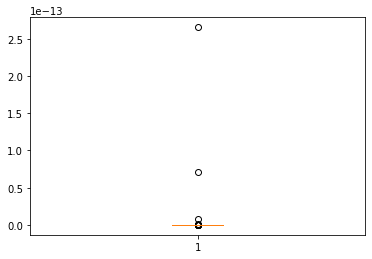

In [15]:
print(pmatrix.shape)

pmeans=np.zeros([50])
#likelihood = np.zeros([kvalues,reps,fastslow])
# compare all k pairs to see if the p values are significant

count=0
for i in range(3,8):
    for j in range(9,19):
        #print(i,j,pmatrix[i,j],count)
        pmeans[count]=pmatrix[i,j]
        count=count+1
print(count-1)
print(statistics.median(pmeans))
print(statistics.mean(pmeans))
plt.boxplot(pmeans)
plt.show()

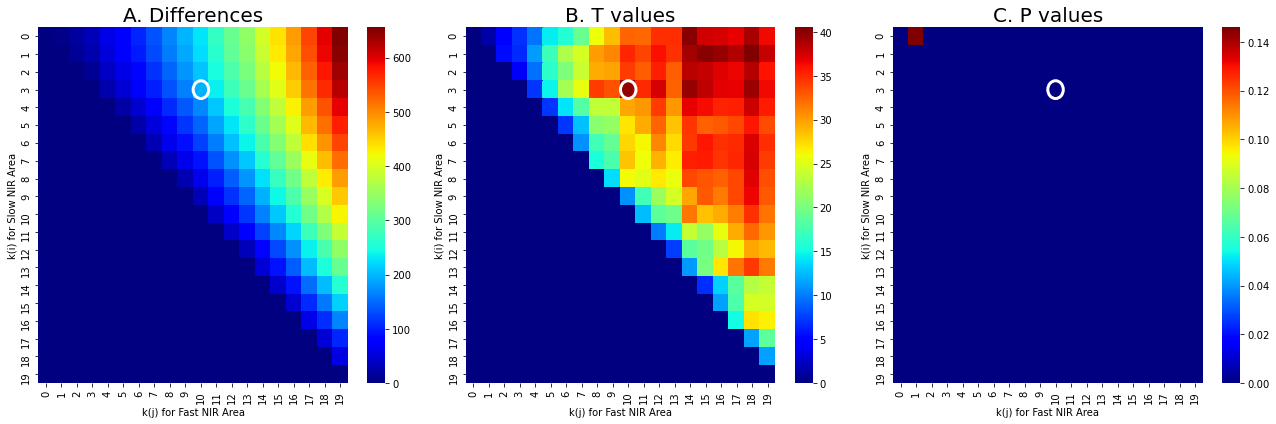

In [16]:
# 3 display the segmentation
color='jet'
ec='black'
scale=0.9
lw=2

fs1 = 14
fs2 = 20



fig=plt.figure(figsize=(18, 6))

fig.add_subplot(131)
ax = fig.gca()
circle2 = plt.Circle((10.5, 3.5), 0.5, color='w', fill=False,  lw=3)
ax.add_patch(circle2)
sns.heatmap(dmatrix, cmap=color)
plt.title('A. Differences', fontsize = fs2)
ax.set_xlabel('k(j) for Fast NIR Area')
ax.set_ylabel('k(i) for Slow NIR Area')

fig.add_subplot(132)
ax = fig.gca()
circle2 = plt.Circle((10.5, 3.5), 0.5, color='w', fill=False,  lw=3)
ax.add_patch(circle2)
sns.heatmap(tmatrix, cmap=color)
plt.title('B. T values', fontsize = fs2)
ax.set_xlabel('k(j) for Fast NIR Area')
ax.set_ylabel('k(i) for Slow NIR Area')

fig.add_subplot(133)
ax = fig.gca()
circle2 = plt.Circle((10.5, 3.5), 0.5, color='w', fill=False,  lw=3)
ax.add_patch(circle2)
sns.heatmap(pmatrix, cmap=color)
plt.title('C. P values', fontsize = fs2)
ax.set_xlabel('k(j) for Fast NIR Area')
ax.set_ylabel('k(i) for Slow NIR Area')

fig.tight_layout()
plt.savefig('CHARMWIP1.png')

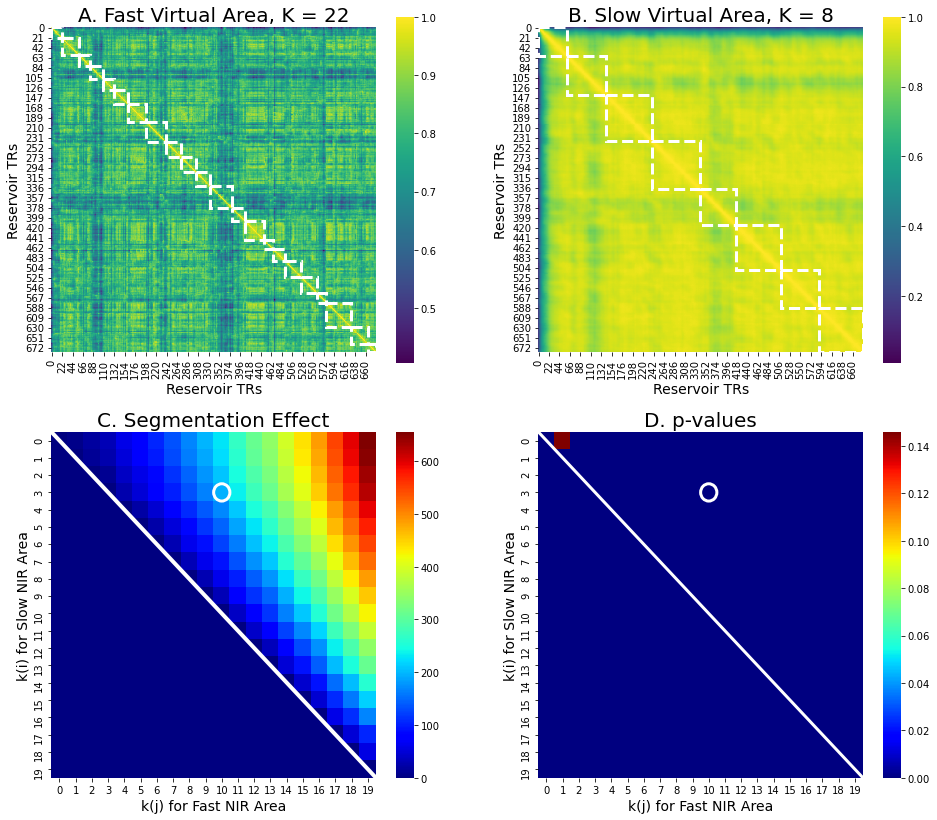

In [17]:
#new figure with the example and then the grid search
# display the segmentation
color='viridis'
ec='white'
scale=0.9
lw=3

fs1 = 14
fs2 = 20

nTR=682
fig=plt.figure(figsize=(16, 14))

fig.add_subplot(221)
bounds = np.where(np.diff(np.argmax(ev_time1.segments_[0], axis=1)))[0]

#plt.imshow(np.corrcoef(NTF_time1),cmap=color, vmin=scale, vmax=1)
#plt.imshow(np.corrcoef(NTF_time1),cmap=color)
sns.heatmap(np.corrcoef(NTF_time1), cmap = 'viridis',square=True)

ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=lw, linestyle='--',edgecolor=ec,facecolor='none')
    ax.add_patch(rect)

plt.xlabel('Reservoir TRs', fontsize = fs1)
plt.ylabel('Reservoir TRs', fontsize = fs1)

plt.title('A. Fast Virtual Area, K = 22', fontsize = fs2)

fig.add_subplot(222)
bounds = np.where(np.diff(np.argmax(ev_time2.segments_[0], axis=1)))[0]

#plt.imshow(np.corrcoef(NTF_time2),cmap=color, vmin=scale, vmax=1)
#plt.imshow(np.corrcoef(NTF_time2),cmap=color)
sns.heatmap(np.corrcoef(NTF_time2), cmap = 'viridis',square=True)

ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=lw, linestyle='--',edgecolor=ec,facecolor='none')
    ax.add_patch(rect)

plt.xlabel('Reservoir TRs', fontsize = fs1)
plt.ylabel('Reservoir TRs', fontsize = fs1)

plt.title('B. Slow Virtual Area, K = 8', fontsize = fs2)

##########################
color = 'jet'
fig.add_subplot(223)
ax = fig.gca()
circle2 = plt.Circle((10.5, 3.5), 0.5, color='w', fill=False,  lw=3)
ax.add_patch(circle2)
sns.heatmap(dmatrix, cmap=color)
plt.title('C. Segmentation Effect', fontsize = fs2)
ax.set_xlabel('k(j) for Fast NIR Area', fontsize = fs1)
ax.set_ylabel('k(i) for Slow NIR Area', fontsize = fs1)
ax.plot([1,0], [0,1], transform=ax.transAxes, color='w', lw=4)



fig.add_subplot(224)
ax = fig.gca()
circle2 = plt.Circle((10.5, 3.5), 0.5, color='w', fill=False,  lw=3)
ax.add_patch(circle2)
sns.heatmap(pmatrix, cmap=color)
plt.title('D. p-values', fontsize = fs2)
ax.set_xlabel('k(j) for Fast NIR Area', fontsize = fs1)
ax.set_ylabel('k(i) for Slow NIR Area', fontsize = fs1)
ax.plot([1,0], [0,1], transform=ax.transAxes, color='w',lw=3)




#fig.tight_layout()
plt.savefig('F10-Exp4-Combined.png', dpi=600)


In [18]:
for j in range(99):
    mean = NTF_time1[:,j].mean()
    if abs(mean) > 0.01: #WAS .01
        NTF_time1[:,j] = NTF_time1[:,j]/mean

for j in range(99):
    mean = NTF_time2[:,j].mean()
    if abs(mean) > 0.01:
        NTF_time2[:,j] = NTF_time2[:,j]/mean

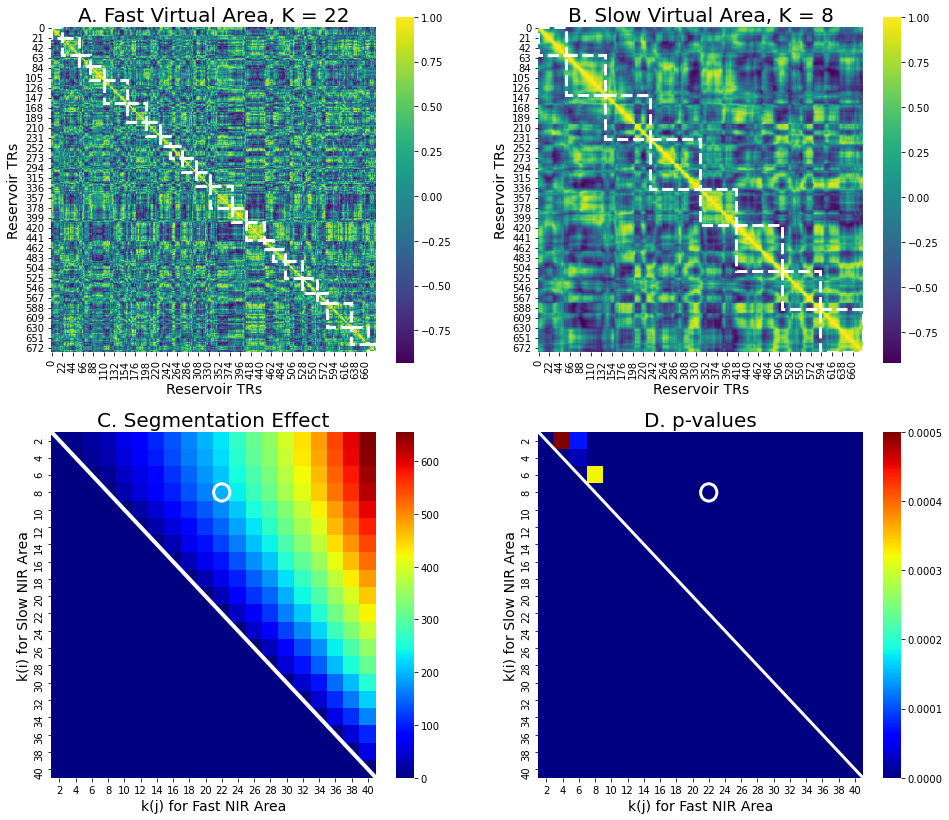

In [55]:
#new figure with the example and then the grid search
# display the segmentation
color='viridis'
ec='white'
scale=0.9
lw=3

fs1 = 14
fs2 = 20

nTR=682
fig=plt.figure(figsize=(16, 14))

fig.add_subplot(221)
bounds = np.where(np.diff(np.argmax(ev_time1.segments_[0], axis=1)))[0]

#plt.imshow(np.corrcoef(NTF_time1),cmap=color, vmin=scale, vmax=1)
#plt.imshow(np.corrcoef(NTF_time1),cmap=color)
sns.heatmap(np.corrcoef(NTF_time1), cmap = 'viridis',square=True)

ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=lw, linestyle='--',edgecolor=ec,facecolor='none')
    ax.add_patch(rect)

plt.xlabel('Reservoir TRs', fontsize = fs1)
plt.ylabel('Reservoir TRs', fontsize = fs1)

plt.title('A. Fast Virtual Area, K = 22', fontsize = fs2)

fig.add_subplot(222)
bounds = np.where(np.diff(np.argmax(ev_time2.segments_[0], axis=1)))[0]

#plt.imshow(np.corrcoef(NTF_time2),cmap=color, vmin=scale, vmax=1)
#plt.imshow(np.corrcoef(NTF_time2),cmap=color)
sns.heatmap(np.corrcoef(NTF_time2), cmap = 'viridis',square=True)

ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=lw, linestyle='--',edgecolor=ec,facecolor='none')
    ax.add_patch(rect)

plt.xlabel('Reservoir TRs', fontsize = fs1)
plt.ylabel('Reservoir TRs', fontsize = fs1)

plt.title('B. Slow Virtual Area, K = 8', fontsize = fs2)

##########################

A1 = np.linspace(2,40,20, dtype=int)
A2 = np.linspace(2,40,20, dtype=int)

color = 'jet'
fig.add_subplot(223)
ax = fig.gca()
circle2 = plt.Circle((10.5, 3.5), 0.5, color='w', fill=False,  lw=3)
ax.add_patch(circle2)
sns.heatmap(dmatrix, cmap=color, xticklabels=A1, yticklabels=A2)
plt.title('C. Segmentation Effect', fontsize = fs2)
ax.set_xlabel('k(j) for Fast NIR Area', fontsize = fs1)
ax.set_ylabel('k(i) for Slow NIR Area', fontsize = fs1)
ax.plot([1,0], [0,1], transform=ax.transAxes, color='w', lw=4)



fig.add_subplot(224)
ax = fig.gca()
circle2 = plt.Circle((10.5, 3.5), 0.5, color='w', fill=False,  lw=3)
ax.add_patch(circle2)
sns.heatmap(pmatrix, cmap=color, xticklabels=A1, yticklabels=A2,vmax=0.0005)
plt.title('D. p-values', fontsize = fs2)
ax.set_xlabel('k(j) for Fast NIR Area', fontsize = fs1)
ax.set_ylabel('k(i) for Slow NIR Area', fontsize = fs1)
ax.plot([1,0], [0,1], transform=ax.transAxes, color='w',lw=3)




#fig.tight_layout()
plt.savefig('CHARMWIP3-validation.png', dpi=600)


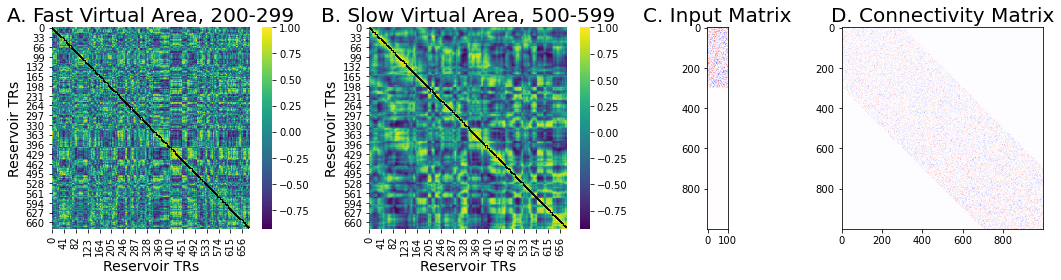

In [42]:
# 3 display the segmentation
color='gist_rainbow'
ec='black'
scale=0.3
lw=1

fs1 = 14
fs2 = 20

nTR=682
fig= plt.figure(figsize=(15,4))

gs = gridspec.GridSpec(1, 4,width_ratios=[4,4,1,4])
plt.subplot(gs[0])


bounds = np.where(np.diff(np.argmax(ev_time1.segments_[0], axis=1)))[0]

sns.heatmap(np.corrcoef(NTF_time1), cmap = 'viridis')

ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=lw, linestyle='--',edgecolor=ec,facecolor='none')
    ax.add_patch(rect)

plt.xlabel('Reservoir TRs', fontsize = fs1)
plt.ylabel('Reservoir TRs', fontsize = fs1)

plt.title('A. Fast Virtual Area, 200-299', fontsize = fs2)

plt.subplot(gs[1])
bounds = np.where(np.diff(np.argmax(ev_time2.segments_[0], axis=1)))[0]

sns.heatmap(np.corrcoef(NTF_time2), cmap = 'viridis')
ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=lw, linestyle='--',edgecolor=ec,facecolor='none')
    ax.add_patch(rect)

plt.xlabel('Reservoir TRs', fontsize = fs1)
plt.ylabel('Reservoir TRs', fontsize = fs1)

plt.title('B. Slow Virtual Area, 500-599', fontsize = fs2)

plt.subplot(gs[2])
plt.imshow(esn._WInput,cmap='seismic' )
plt.title('C. Input Matrix', fontsize = fs2)

plt.subplot(gs[3])
plt.imshow(esn._W,cmap='seismic' )
plt.title('D. Connectivity Matrix', fontsize = fs2)


fig.tight_layout()
plt.savefig('MatrixSegmentationExhaustive.png')

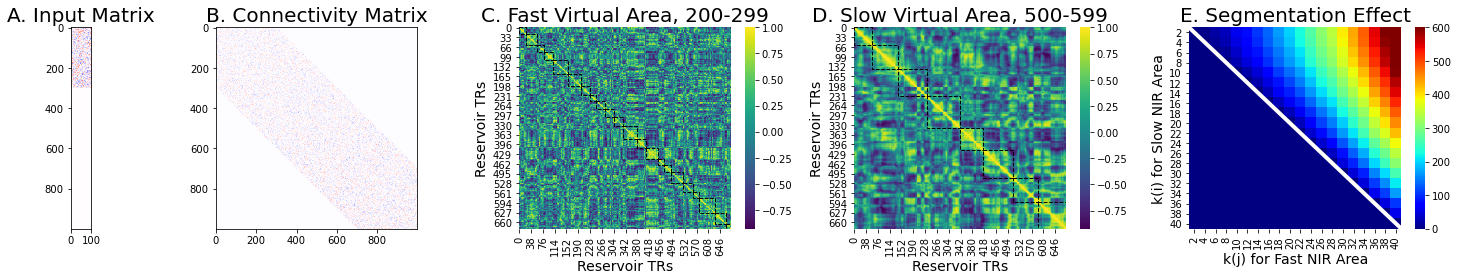

In [69]:
# 3 display the segmentation
color='gist_rainbow'
ec='black'
scale=0.3
lw=1

fs1 = 14
fs2 = 20

nTR=682
fig= plt.figure(figsize=(20,4))

gs = gridspec.GridSpec(1, 5,width_ratios=[1,4,4,4,4])
plt.subplot(gs[2])


bounds = np.where(np.diff(np.argmax(ev_time1.segments_[0], axis=1)))[0]

sns.heatmap(np.corrcoef(NTF_time1), cmap = 'viridis')

ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=lw, linestyle='--',edgecolor=ec,facecolor='none')
    ax.add_patch(rect)

plt.xlabel('Reservoir TRs', fontsize = fs1)
plt.ylabel('Reservoir TRs', fontsize = fs1)

plt.title('C. Fast Virtual Area, 200-299', fontsize = fs2)

plt.subplot(gs[3])
bounds = np.where(np.diff(np.argmax(ev_time2.segments_[0], axis=1)))[0]

sns.heatmap(np.corrcoef(NTF_time2), cmap = 'viridis')
ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=lw, linestyle='--',edgecolor=ec,facecolor='none')
    ax.add_patch(rect)

plt.xlabel('Reservoir TRs', fontsize = fs1)
plt.ylabel('Reservoir TRs', fontsize = fs1)

plt.title('D. Slow Virtual Area, 500-599', fontsize = fs2)

plt.subplot(gs[0])
plt.imshow(esn._WInput,cmap='seismic' )
plt.title('A. Input Matrix', fontsize = fs2)

plt.subplot(gs[1])
plt.imshow(esn._W,cmap='seismic' )
plt.title('B. Connectivity Matrix', fontsize = fs2)

plt.subplot(gs[4])
ax =sns.heatmap(dmatrix, cmap='jet', xticklabels=A1, yticklabels=A2, vmax = 600)
plt.title('E. Segmentation Effect', fontsize = fs2)
ax.set_xlabel('k(j) for Fast NIR Area', fontsize = fs1)
ax.set_ylabel('k(i) for Slow NIR Area', fontsize = fs1)
ax.plot([1,0], [0,1], transform=ax.transAxes, color='w', lw=4)



fig.tight_layout()
plt.savefig('MatrixSegmentationExhaustive.png')

Text(0, 0.5, 'Log likelihood difference')

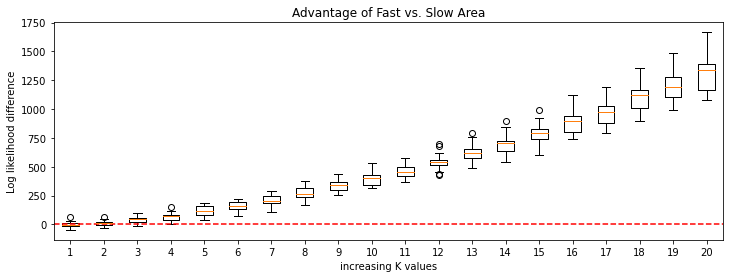

In [20]:
#likelihood = np.zeros([kvalues,reps,fastslow])
# small K is slow, likelihood 1 is slow
# high K is fast, likelihood 0 is fast

#model k
#slow slow - fast slow
#slow fast - fast fast


f, ax = plt.subplots(1,1, figsize=(12, 4))

ax.boxplot(likelihood[:,:,0].T-likelihood[:,:,1].T)
#ax.boxplot(likelihood[:,:,0].T)
#ax.boxplot(likelihood[:,:,1].T)
#ax.boxplot(likelihood)
#ax.plot(likelihood[:,1])

plt.axhline(y=0, color='r', linestyle='--')


ax.set_title('Advantage of Fast vs. Slow Area')
ax.set_xlabel('increasing K values')
ax.set_ylabel('Log likelihood difference')
#
#sns.despine()

(array([2., 0., 1., 3., 5., 3., 2., 1., 2., 1.]),
 array([-1517.9508072 , -1505.922688  , -1493.8945688 , -1481.8664496 ,
        -1469.83833041, -1457.81021121, -1445.78209201, -1433.75397281,
        -1421.72585361, -1409.69773441, -1397.66961521]),
 <BarContainer object of 10 artists>)

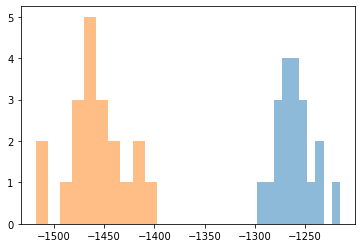

In [21]:
data3 = (likelihood[3,:,0]+ likelihood[10,:,1])/2
data4 = (likelihood[10,:,0]+ likelihood[3,:,1])/2

plt.hist(data4, alpha=0.5)
plt.hist(data3,alpha=0.5)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f120a6e2750>,
 'caps': [<matplotlib.lines.Line2D at 0x7f120a6e2fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f120a6e2350>,
 'medians': [<matplotlib.lines.Line2D at 0x7f120a6eb8d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f120a6ebd10>,
 'means': []}

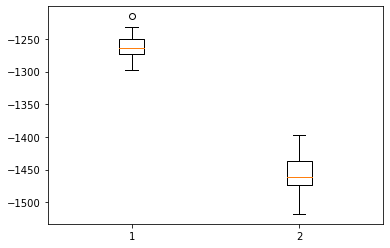

In [22]:
plt.boxplot([data4,data3])

In [23]:
#4 15 4.307048321216739 7.923701639107483e-05
t,p = stats.ttest_rel(data4,data3)
print(t)
print(p)
print(np.mean(data4-data3))

39.77058251234509
9.255779646307191e-20
196.48199679230498


In [24]:
print(np.shape(likelihood))
print(kvalues)

(20, 20, 2)
20


<AxesSubplot:>

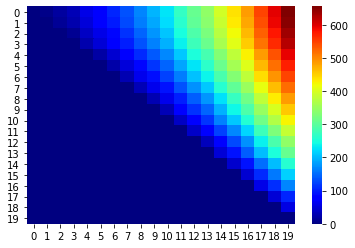

In [25]:
sns.heatmap(dmatrix,cmap='jet')

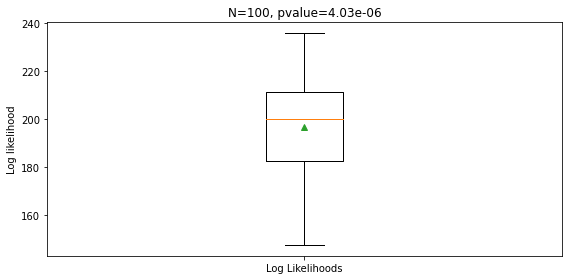

In [26]:

fig=plt.figure(figsize=(8, 4))
#f,ax = plt.subplots(1,1, figsize=(5, 5))
plt.boxplot(data4-data3,showmeans=True)
#plt.xlabel('Coherent                                    Incoherent')
plt.ylabel('Log likelihood')
#plt.axhline(y=0, color='r', linestyle='--')

plt.xticks([1], ['Log Likelihoods'])#ax.set_xticklabels(['Coherent-Incoherent'])
plt.title('N=100, pvalue=4.03e-06')
fig.tight_layout()
plt.savefig('temp2.png')

In [27]:
#likelihood = np.load('likelihood-june10.npy')

In [28]:
#np.save('NTF-time1-june6.npy', NTF_time1) 
#np.save('NTF-time2-june6.npy', NTF_time2) 

#np.save('likelihood-june6.npy', likelihood) 

#NTF_time1 = np.load('NTF-time1-last-june10.npy')
#NTF_time2 = np.load('NTF-time2-last-june10.npy')

In [29]:
#NTF_time1 = np.load('NTF-time1-june10.npy')
#NTF_time2 = np.load('NTF-time2-june10.npy')

In [30]:
# save likelihood scores
print('liklihood')
print(ev_time1.ll_[len(ev_time1.ll_)-1])
print(ev_time2.ll_[len(ev_time2.ll_)-1])


liklihood
[-973.39210598]
[-943.45455415]


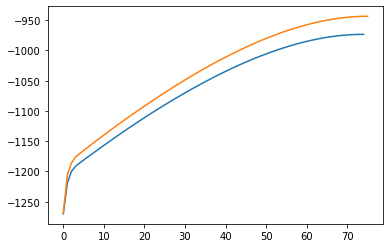

In [31]:
plt.plot(ev_time1.ll_)
plt.plot(ev_time2.ll_)

In [32]:
NTF_time1 = NTF_time1_cumul/reps
NTF_time2 = NTF_time2_cumul/reps

In [33]:
NTF_time1 = NTF_time1_last
NTF_time2 = NTF_time2_last

In [34]:
ev_time1 = brainiak.eventseg.event.EventSegment(200)
ev_time1.fit(NTF_time1)

ev_time2 = brainiak.eventseg.event.EventSegment(200)
ev_time2.fit(NTF_time2)

EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
             n_events=200)

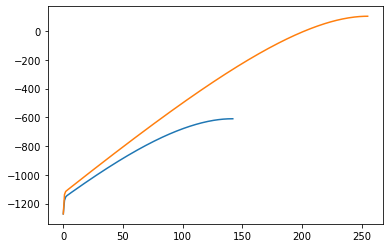

In [35]:
plt.plot(ev_time1.ll_)
plt.plot(ev_time2.ll_)

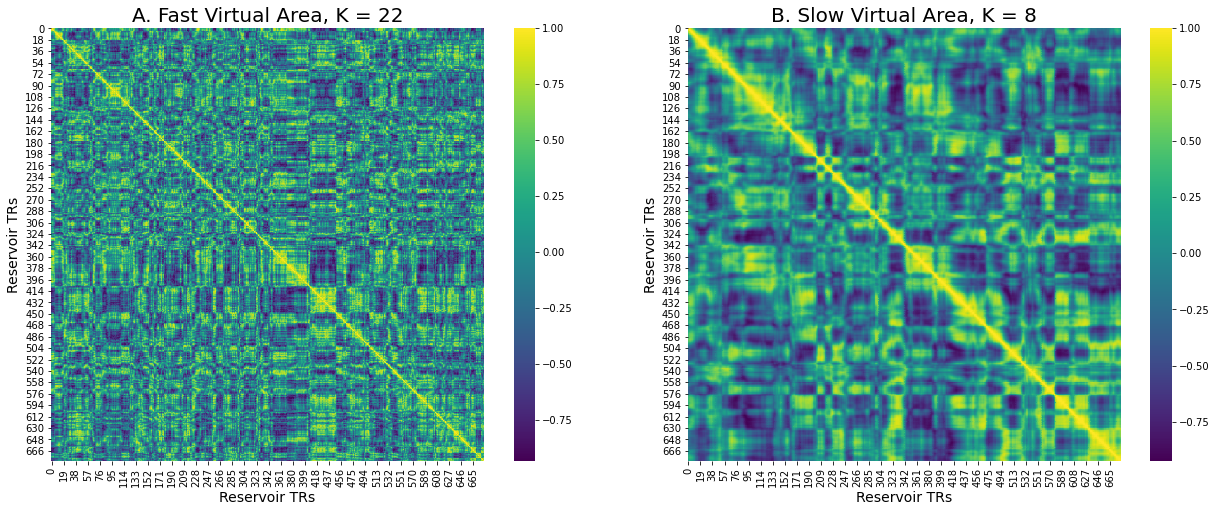

In [36]:
# 3 display the segmentation
color='viridis'
ec='white'
scale=0.9
lw=3

fs1 = 14
fs2 = 20

nTR=682
fig=plt.figure(figsize=(18, 7))

fig.add_subplot(121)
sns.heatmap(np.corrcoef(NTF_time1), cmap = 'viridis',square=True)

ax = plt.gca()

plt.xlabel('Reservoir TRs', fontsize = fs1)
plt.ylabel('Reservoir TRs', fontsize = fs1)

plt.title('A. Fast Virtual Area, K = 22', fontsize = fs2)

fig.add_subplot(122)
sns.heatmap(np.corrcoef(NTF_time2), cmap = 'viridis',square=True)

ax = plt.gca()

plt.xlabel('Reservoir TRs', fontsize = fs1)
plt.ylabel('Reservoir TRs', fontsize = fs1)

plt.title('B. Slow Virtual Area, K = 8', fontsize = fs2)


fig.tight_layout()
plt.savefig('CHARMwip.png')

In [37]:
print(NTF_time1.shape)

(682, 99)


In [38]:
for j in range(99):
    mean = NTF_time1[:,j].mean()
    if abs(mean) > 0.01: #WAS .01
        NTF_time1[:,j] = NTF_time1[:,j]/mean

for j in range(99):
    mean = NTF_time2[:,j].mean()
    if abs(mean) > 0.01:
        NTF_time2[:,j] = NTF_time2[:,j]/mean
